<a href="https://colab.research.google.com/github/elilaird/Stats202-FinalProject/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
study_A = pd.read_csv("/content/drive/My Drive/Stats202_FinalProject/Data/Study_A.csv")
study_B = pd.read_csv("/content/drive/My Drive/Stats202_FinalProject/Data/Study_B.csv")
study_C = pd.read_csv("/content/drive/My Drive/Stats202_FinalProject/Data/Study_C.csv")
study_D = pd.read_csv("/content/drive/My Drive/Stats202_FinalProject/Data/Study_D.csv")
study_E = pd.read_csv("/content/drive/My Drive/Stats202_FinalProject/Data/Study_E.csv")

targets = pd.read_csv("/content/drive/My Drive/Stats202_FinalProject/Data/sample_submission_status.csv")

#merge datasets
full_set = pd.concat([study_A, study_B, study_C, study_D])
full_set = full_set.reset_index(drop=True)


testing_data = pd.DataFrame(study_E)

In [52]:
targets.shape

(1962, 2)

###Pre-processing

In [53]:
training_data = pd.DataFrame(full_set)
training_data.head()

,Study,Country,PatientID,SiteID,RaterID,AssessmentiD,TxGroup,VisitDay,P1,P2,P3,P4,P5,P6,P7,N1,N2,N3,N4,N5,N6,N7,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,G13,G14,G15,G16,PANSS_Total,LeadStatus
0,A,USA,10001,20035,30076,100679,Control,0,5,5,5,3,4,5,3,4,4,3,4,4,3,2,3,4,4,4,1,4,1,3,5,3,3,4,3,3,3,5,107,Assign to CS
1,A,USA,10001,20035,30076,101017,Control,11,5,5,5,3,4,5,3,4,4,3,4,4,3,3,4,4,4,4,1,4,1,3,5,3,3,4,3,3,3,5,109,Assign to CS
2,A,USA,10001,20035,30076,102177,Control,18,4,4,4,3,2,4,2,4,4,3,4,4,3,2,3,3,3,3,1,4,2,2,4,2,2,3,3,2,3,4,91,Passed
3,A,USA,10001,20035,30076,101533,Control,25,3,3,3,2,2,4,2,4,4,2,4,4,2,2,3,3,2,2,1,2,2,2,3,2,2,3,3,2,3,4,80,Flagged
4,A,USA,10001,20035,30076,100930,Control,39,3,3,4,2,1,4,2,4,4,2,4,4,1,2,3,3,1,2,1,1,2,2,3,2,2,3,3,2,3,4,77,Flagged


In [54]:
training_data['LeadStatus'].value_counts()

Passed          15841
Flagged          2630
Assign to CS     2476
Name: LeadStatus, dtype: int64

####Encode LeadStatus values as 1 for 'Flagged' and  0 for 'Assign to CS'

In [55]:
training_data = training_data[training_data['LeadStatus'] != 'Passed']
training_data['LeadStatus'] = training_data['LeadStatus'].map({'Assign to CS': 0, 'Flagged': 1})
training_data['LeadStatus'].unique()

array([0, 1])

In [56]:
training_data.shape

(5106, 40)

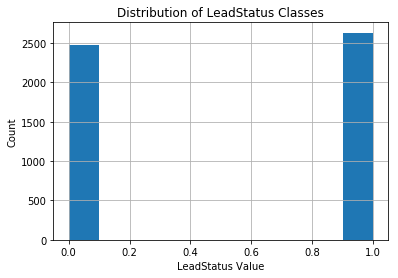

In [59]:
training_data['LeadStatus'].hist()
plt.title("Distribution of LeadStatus Classes")
plt.xlabel("LeadStatus Value")
plt.ylabel("Count")
plt.savefig('/content/drive/My Drive/Stats202_FinalProject/Figures/class_distribution.png')

####Check to see if the nominal variables have common values in each set

In [0]:
#check if training and test sets have common assessmentiDs
train_assessmentids = set(training_data['AssessmentiD'])
test_assessmentids = set(testing_data['AssessmentiD'])

common_assessmentids = train_assessmentids.intersection(test_assessmentids)
print(len(common_assessmentids))

0


There are no common assessmentids in both sets, therefore we can leave out the assessmentid variable in modeling

In [0]:
#check if training and test sets have common SiteIds
train_siteIds = set(training_data['SiteID'])
test_siteIds = set(testing_data['SiteID'])

common_siteIds = train_siteIds.intersection(test_siteIds)
print(len(common_siteIds))

0


There are no common siteIDs, therefore we can leave out the siteID variable in modeling

In [0]:
#check if training and test sets have common raterIDs
train_raterIds = set(training_data['RaterID'])
test_raterIds = set(testing_data['RaterID'])

common_raterIds = train_raterIds.intersection(test_raterIds)
print(len(common_raterIds))

0


There are no common raterIds, therefore we can leave out the raterId variable in modeling

In [0]:
#check if training and test sets have common PatientIds
train_patientIds = set(training_data['PatientID'])
test_patientIds = set(testing_data['PatientID'])

common_patientIds = train_patientIds.intersection(test_patientIds)
print(len(common_patientIds))

0


There are no common patientIds, therefore we can leave out the patientIds variable in modeling

In [0]:
#remove variables with uncommon values in training and testing data
training_data = training_data.drop(['RaterID','PatientID','SiteID','Study'], axis=1)
testing_data = testing_data.drop(['RaterID','PatientID','SiteID','Study'], axis=1)

####One-hot encoding for categorical variables

In [0]:
#one-hot encode categorical variables
training_data = pd.get_dummies(training_data)
testing_data = pd.get_dummies(testing_data)

print('Training data shape: ', training_data.shape)
print('Testing data shape: ', testing_data.shape)

Training data shape:  (5106, 63)
Testing data shape:  (1962, 38)


####Align training and testing data

In [0]:
training_labels = training_data['LeadStatus']

training_data, testing_data = training_data.align(testing_data, join= 'inner', axis=1)

training_data['LeadStatus'] = training_labels

In [0]:
print('Training data shape: ', training_data.shape)
print('Testing data shape: ', testing_data.shape)

Training data shape:  (5106, 38)
Testing data shape:  (1962, 37)


####Find correlations to target variable

In [0]:
correlations = training_data.corr()['LeadStatus'].sort_values()

print('Correlations:\n', correlations)


Correlations:
 Country_Russia      -0.262025
PANSS_Total         -0.197583
G13                 -0.182113
N3                  -0.178561
G4                  -0.169583
N7                  -0.168707
G11                 -0.168548
N4                  -0.167135
G5                  -0.165749
N6                  -0.162785
N1                  -0.160665
G16                 -0.157852
N2                  -0.143961
P2                  -0.138131
G8                  -0.137335
G15                 -0.133429
G14                 -0.116247
P7                  -0.107341
P1                  -0.103359
P6                  -0.101956
G12                 -0.101542
P4                  -0.100231
G7                  -0.097085
P5                  -0.086644
G9                  -0.082247
N5                  -0.079822
G3                  -0.070897
G2                  -0.070578
G10                 -0.065303
P3                  -0.048482
G6                  -0.032971
G1                  -0.026934
TxGroup_Treatment   -0.00

###Feature Engineering

In [0]:
#create copies of training and testing data for feature engineering
training_copy = training_data.copy()
testing_copy = testing_data.copy()

#####Combine the symptom scores into totals

In [0]:
#add columns for sums of Positive, Negative, General Symptoms
training_copy['Total_P'] = training_copy['P1'] + training_copy['P2'] + training_copy['P3'] + training_copy['P4'] + training_copy['P5'] + training_copy['P6'] + training_copy['P7']
training_copy['Total_N'] = training_copy['N1'] + training_copy['N2'] + training_copy['N3'] + training_copy['N4'] + training_copy['N5'] + training_copy['N6'] + training_copy['N7']
training_copy['Total_G'] = training_copy['G1'] + training_copy['G2'] + training_copy['G3'] + training_copy['G4'] + training_copy['G5'] + training_copy['G6'] + training_copy['G7'] + training_copy['G8'] + training_copy['G9'] + training_copy['G10'] + training_copy['G11'] + training_copy['G12'] + training_copy['G13'] + training_copy['G14'] + training_copy['G15'] + training_copy['G16']

testing_copy['Total_P'] = testing_copy['P1'] + testing_copy['P2'] + testing_copy['P3'] + testing_copy['P4'] + testing_copy['P5'] + testing_copy['P6'] + testing_copy['P7']
testing_copy['Total_N'] = testing_copy['N1'] + testing_copy['N2'] + testing_copy['N3'] + testing_copy['N4'] + testing_copy['N5'] + testing_copy['N6'] + testing_copy['N7']
testing_copy['Total_G'] = testing_copy['G1'] + testing_copy['G2'] + testing_copy['G3'] + testing_copy['G4'] + testing_copy['G5'] + testing_copy['G6'] + testing_copy['G7'] + testing_copy['G8'] + testing_copy['G9'] + testing_copy['G10'] + testing_copy['G11'] + testing_copy['G12'] + testing_copy['G13'] + testing_copy['G14'] + testing_copy['G15'] + testing_copy['G16']

training_copy = training_copy.drop(['P1','P2','P3','P4','P5','P6','P7','N1','N2','N3','N4','N5','N6','N7','G1','G2','G3','G4','G5','G6','G7','G8','G9','G10','G11','G12','G13','G14','G15','G16'], axis=1)
testing_copy = testing_copy.drop(['P1','P2','P3','P4','P5','P6','P7','N1','N2','N3','N4','N5','N6','N7','G1','G2','G3','G4','G5','G6','G7','G8','G9','G10','G11','G12','G13','G14','G15','G16'], axis=1)

In [0]:
training_copy.shape

(5106, 11)

In [60]:
training_copy.to_excel('/content/drive/My Drive/Stats202_FinalProject/Figures/classification_preprocessing_data.xlsx')
training_copy.head()

,AssessmentiD,VisitDay,PANSS_Total,Country_Russia,Country_USA,TxGroup_Control,TxGroup_Treatment,LeadStatus,Total_P,Total_N,Total_G
0,100679,0,107,0,1,1,0,0,30,24,53
1,101017,11,109,0,1,1,0,0,30,25,54
3,101533,25,80,0,1,1,0,1,19,22,39
4,100930,39,77,0,1,1,0,1,19,21,37
5,100471,53,75,0,1,1,0,1,18,20,37


#####Test correlations of new columns to LeadStatus

In [64]:
correlations = training_copy.corr()['LeadStatus'].sort_values()
pd.DataFrame(correlations).to_excel('/content/drive/My Drive/Stats202_FinalProject/Figures/classification_correlations_data.xlsx')

print(correlations)

Country_Russia      -0.262025
Total_N             -0.200459
PANSS_Total         -0.197583
Total_G             -0.193581
Total_P             -0.126087
TxGroup_Treatment   -0.001048
TxGroup_Control      0.001048
AssessmentiD         0.109325
Country_USA          0.130874
VisitDay             0.236742
LeadStatus           1.000000
Name: LeadStatus, dtype: float64


####Add polynomial features

In [0]:
#create copy of data for polynomial testing
training_poly = training_copy[['Total_N','Total_P','Total_G','PANSS_Total','VisitDay','LeadStatus']]
testing_poly = testing_copy[['Total_N','Total_P','Total_G','PANSS_Total','VisitDay']]

training_labels = training_poly['LeadStatus']
training_poly = training_poly.drop(['LeadStatus'], axis=1)
feature_names = ['Total_N','Total_P','Total_G','PANSS_Total','VisitDay']

#imputer used to fill missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy= 'median')

#impute missing values
training_poly = imputer.fit_transform(training_poly)
testing_poly = imputer.transform(testing_poly)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree= 3)

#train the polynomial features
poly_transformer.fit(training_poly)

#transform features
training_poly = poly_transformer.transform(training_poly)
testing_poly = poly_transformer.transform(testing_poly)
print('Polynomial Features shape: ', training_poly.shape)

Polynomial Features shape:  (5106, 56)


In [0]:
poly_feature_names = poly_transformer.get_feature_names(input_features= feature_names)
poly_feature_names[:20]

['1',
 'Total_N',
 'Total_P',
 'Total_G',
 'PANSS_Total',
 'VisitDay',
 'Total_N^2',
 'Total_N Total_P',
 'Total_N Total_G',
 'Total_N PANSS_Total',
 'Total_N VisitDay',
 'Total_P^2',
 'Total_P Total_G',
 'Total_P PANSS_Total',
 'Total_P VisitDay',
 'Total_G^2',
 'Total_G PANSS_Total',
 'Total_G VisitDay',
 'PANSS_Total^2',
 'PANSS_Total VisitDay']

In [66]:
len(poly_feature_names)

56

In [0]:
#create dataframe with poly features
training_poly = pd.DataFrame(training_poly, columns= poly_feature_names)

#add back LeadStatus
training_poly['LeadStatus'] = training_labels

#remove nan features
training_poly = training_poly.dropna()

training_poly.isnull().values.sum()



0

In [0]:
training_poly.head()

,1,Total_N,Total_P,Total_G,PANSS_Total,VisitDay,Total_N^2,Total_N Total_P,Total_N Total_G,Total_N PANSS_Total,Total_N VisitDay,Total_P^2,Total_P Total_G,Total_P PANSS_Total,Total_P VisitDay,Total_G^2,Total_G PANSS_Total,Total_G VisitDay,PANSS_Total^2,PANSS_Total VisitDay,VisitDay^2,Total_N^3,Total_N^2 Total_P,Total_N^2 Total_G,Total_N^2 PANSS_Total,Total_N^2 VisitDay,Total_N Total_P^2,Total_N Total_P Total_G,Total_N Total_P PANSS_Total,Total_N Total_P VisitDay,Total_N Total_G^2,Total_N Total_G PANSS_Total,Total_N Total_G VisitDay,Total_N PANSS_Total^2,Total_N PANSS_Total VisitDay,Total_N VisitDay^2,Total_P^3,Total_P^2 Total_G,Total_P^2 PANSS_Total,Total_P^2 VisitDay,Total_P Total_G^2,Total_P Total_G PANSS_Total,Total_P Total_G VisitDay,Total_P PANSS_Total^2,Total_P PANSS_Total VisitDay,Total_P VisitDay^2,Total_G^3,Total_G^2 PANSS_Total,Total_G^2 VisitDay,Total_G PANSS_Total^2,Total_G PANSS_Total VisitDay,Total_G VisitDay^2,PANSS_Total^3,PANSS_Total^2 VisitDay,PANSS_Total VisitDay^2,VisitDay^3,LeadStatus
0,1.0,24.0,30.0,53.0,107.0,0.0,576.0,720.0,1272.0,2568.0,0.0,900.0,1590.0,3210.0,0.0,2809.0,5671.0,0.0,11449.0,0.0,0.0,13824.0,17280.0,30528.0,61632.0,0.0,21600.0,38160.0,77040.0,0.0,67416.0,136104.0,0.0,274776.0,0.0,0.0,27000.0,47700.0,96300.0,0.0,84270.0,170130.0,0.0,343470.0,0.0,0.0,148877.0,300563.0,0.0,606797.0,0.0,0.0,1225043.0,0.0,0.0,0.0,0.0
1,1.0,25.0,30.0,54.0,109.0,11.0,625.0,750.0,1350.0,2725.0,275.0,900.0,1620.0,3270.0,330.0,2916.0,5886.0,594.0,11881.0,1199.0,121.0,15625.0,18750.0,33750.0,68125.0,6875.0,22500.0,40500.0,81750.0,8250.0,72900.0,147150.0,14850.0,297025.0,29975.0,3025.0,27000.0,48600.0,98100.0,9900.0,87480.0,176580.0,17820.0,356430.0,35970.0,3630.0,157464.0,317844.0,32076.0,641574.0,64746.0,6534.0,1295029.0,130691.0,13189.0,1331.0,0.0
3,1.0,21.0,19.0,37.0,77.0,39.0,441.0,399.0,777.0,1617.0,819.0,361.0,703.0,1463.0,741.0,1369.0,2849.0,1443.0,5929.0,3003.0,1521.0,9261.0,8379.0,16317.0,33957.0,17199.0,7581.0,14763.0,30723.0,15561.0,28749.0,59829.0,30303.0,124509.0,63063.0,31941.0,6859.0,13357.0,27797.0,14079.0,26011.0,54131.0,27417.0,112651.0,57057.0,28899.0,50653.0,105413.0,53391.0,219373.0,111111.0,56277.0,456533.0,231231.0,117117.0,59319.0,1.0
4,1.0,20.0,18.0,37.0,75.0,53.0,400.0,360.0,740.0,1500.0,1060.0,324.0,666.0,1350.0,954.0,1369.0,2775.0,1961.0,5625.0,3975.0,2809.0,8000.0,7200.0,14800.0,30000.0,21200.0,6480.0,13320.0,27000.0,19080.0,27380.0,55500.0,39220.0,112500.0,79500.0,56180.0,5832.0,11988.0,24300.0,17172.0,24642.0,49950.0,35298.0,101250.0,71550.0,50562.0,50653.0,102675.0,72557.0,208125.0,147075.0,103933.0,421875.0,298125.0,210675.0,148877.0,1.0
5,1.0,19.0,17.0,36.0,72.0,67.0,361.0,323.0,684.0,1368.0,1273.0,289.0,612.0,1224.0,1139.0,1296.0,2592.0,2412.0,5184.0,4824.0,4489.0,6859.0,6137.0,12996.0,25992.0,24187.0,5491.0,11628.0,23256.0,21641.0,24624.0,49248.0,45828.0,98496.0,91656.0,85291.0,4913.0,10404.0,20808.0,19363.0,22032.0,44064.0,41004.0,88128.0,82008.0,76313.0,46656.0,93312.0,86832.0,186624.0,173664.0,161604.0,373248.0,347328.0,323208.0,300763.0,1.0


In [0]:
#find correlations between poly features and LeadStatus
poly_corrs = training_poly.corr()['LeadStatus'].sort_values()
poly_corrs = poly_corrs.dropna()

#print most negative and most positive correlations
print('Most negative: \n', poly_corrs.head(20),'\n')
print('Most positive: \n', poly_corrs.tail(20),'\n')

Most negative: 
 VisitDay                       -0.119923
VisitDay^2                     -0.085072
Total_P VisitDay^2             -0.060504
Total_G VisitDay               -0.055624
VisitDay^3                     -0.055436
PANSS_Total VisitDay           -0.052923
PANSS_Total VisitDay^2         -0.051977
Total_G VisitDay^2             -0.051368
Total_N VisitDay               -0.049476
Total_P VisitDay               -0.046038
Total_N VisitDay^2             -0.045379
Total_N^2 VisitDay              0.011582
Total_G^2 VisitDay              0.017258
Total_N PANSS_Total VisitDay    0.017352
Total_N Total_G VisitDay        0.017657
Total_G PANSS_Total VisitDay    0.020663
PANSS_Total^2 VisitDay          0.022663
Total_N Total_P VisitDay        0.023784
Total_P Total_G VisitDay        0.030053
Total_P PANSS_Total VisitDay    0.031574
Name: LeadStatus, dtype: float64 

Most positive: 
 Total_N Total_G^2              0.202989
Total_N Total_P PANSS_Total    0.203886
Total_G^2 PANSS_Total          

In [0]:
#put test features into dataframe
testing_poly = pd.DataFrame(testing_poly, columns= poly_transformer.get_feature_names(input_features= feature_names))

#merge poly features into training dataframe
training_poly['AssessmentiD'] = training_copy['AssessmentiD']
training_poly = training_copy.merge(training_poly, on='AssessmentiD', how='left')

#merge poly featuers into testing dataframe
testing_poly['AssessmentiD'] = testing_copy['AssessmentiD']
testing_poly = testing_copy.merge(testing_poly, on='AssessmentiD', how='left')

#Align testing and training dataframes
training_poly, testing_poly = training_poly.align(testing_poly, join='inner', axis=1)

print("Training data with poly features shape: ", training_poly.shape)
print("Testing data with poly features shape: ", testing_poly.shape)

Training data with poly features shape:  (5106, 66)
Testing data with poly features shape:  (1962, 66)


###Split into training and validation sets and scale values

In [0]:
#helper function to scale and impute data
def scale_impute(train_set, val_set, test_set):
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import MinMaxScaler

  #fill in missing values
  imputer.fit(train_set)

  #transform both training and testing data
  train_set = imputer.transform(train_set)
  val_set = imputer.transform(val_set)
  test_set = imputer.transform(test_set)

  #Scale each featuer to 0-1
  scaler = MinMaxScaler(feature_range= (0,1))

  scaler.fit(train_set)
  train_set = scaler.transform(train_set)
  val_set = scaler.transform(val_set)
  test_set = scaler.transform(test_set)

  return (train_set, val_set, test_set)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_val, y_train, y_val = train_test_split(training_poly, training_copy['LeadStatus'], test_size = 0.2, random_state = 1 )


In [0]:
#scale values and impute missing values
X_train, X_val, testing_scaled = scale_impute(X_train, X_val, testing_poly)

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Testing data shape: ', testing_scaled.shape)

Training data shape:  (4084, 66)
Validation data shape:  (1022, 66)
Testing data shape:  (1962, 66)


###Logistic Regression Fit

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score
log_reg = LogisticRegression()

#train on training data
log_reg.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#predict
log_reg_prob = log_reg.predict_proba(X_val)[:,1]
log_pred = log_reg.predict(X_val)

In [87]:
log_reg_prob[:15]

array([0.70490395, 0.48099814, 0.87004942, 0.25950655, 0.26972165,
       0.84238932, 0.11888896, 0.31765884, 0.09194791, 0.37003172,
       0.49795331, 0.59475455, 0.75796535, 0.43570207, 0.1993426 ])

In [88]:
zero_one_loss(y_val,log_pred)

0.23972602739726023

In [89]:
zero_one_loss(y_val,log_pred,normalize=False)

245

In [90]:
accuracy = accuracy_score(y_val, log_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.03%


####Predict on test data

In [0]:
test_prob = log_reg.predict_proba(testing_scaled)[:,1]
test_prob[:15]

test_pred = log_reg.predict(testing_scaled)
test_pred[:15]

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [0]:
results = pd.DataFrame(testing_poly['AssessmentiD'])
results.rename(columns={"AssessmentiD":"AssessmentID"})
results['LeadStatus'] = test_prob

results.to_csv('classification_submission.csv', index = False)

###Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score

In [0]:
rnd_class = RandomForestClassifier(n_estimators=100, max_leaf_nodes= 6, n_jobs=-1)
rnd_class.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
predictions = rnd_class.predict(X_val)

In [0]:
predictions[0:100]

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0])

In [0]:
zero_one_loss(y_val,predictions)

0.19569471624266144

In [0]:
zero_one_loss(y_val,predictions,normalize=False)

200

In [84]:
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.43%


Random forest incorrectly classified only 200 values

####Predict study E 



In [0]:
final_predictions = rnd_class.predict_proba(testing_scaled)

In [0]:
final_preds = rnd_class.predict_proba(testing_scaled)[:,1]
final_preds[0:100]

array([0.44279454, 0.37229636, 0.4481652 , 0.49255744, 0.48170685,
       0.37240323, 0.44443849, 0.48140961, 0.47621763, 0.47222896,
       0.36624033, 0.43237095, 0.47006083, 0.46059618, 0.46605173,
       0.36938113, 0.45400814, 0.50483195, 0.51536468, 0.32185409,
       0.39126164, 0.42750374, 0.41143168, 0.4392001 , 0.33125307,
       0.33125307, 0.37439408, 0.40907978, 0.4148954 , 0.36938049,
       0.45255234, 0.46494672, 0.40635311, 0.40715391, 0.33125307,
       0.38466567, 0.41687096, 0.41414429, 0.40216576, 0.33125307,
       0.41340476, 0.40892137, 0.37730833, 0.33646559, 0.37212453,
       0.4206566 , 0.4132367 , 0.39985303, 0.52916073, 0.55527189,
       0.62122908, 0.62130142, 0.60789042, 0.50439877, 0.56397063,
       0.61734789, 0.41807187, 0.36869373, 0.44452639, 0.48079351,
       0.50015893, 0.47265002, 0.37852896, 0.52178214, 0.47827229,
       0.56816835, 0.53315967, 0.5964258 , 0.59722347, 0.35673265,
       0.41412397, 0.46971194, 0.41708363, 0.39384091, 0.44056

In [0]:
results_random_forest = pd.DataFrame(testing_poly['AssessmentiD'])
results_random_forest.rename(columns={"AssessmentiD":"AssessmentID"})
results_random_forest['LeadStatus'] = final_preds

results_random_forest.to_csv('classification_submission_randforest.csv', index = False)

In [0]:
results_random_forest.head()

,AssessmentiD,LeadStatus
0,501017,0.442795
1,500679,0.372296
2,500930,0.448165
3,502177,0.492557
4,501533,0.481707


###XGBoost

In [75]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()

X_train, X_val, y_train, y_val = train_test_split(training_poly, training_copy['LeadStatus'], test_size = 0.2, random_state = 1 )

X_train, X_val, testing_scaled = scale_impute(X_train, X_val, testing_poly)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

####Observe important features

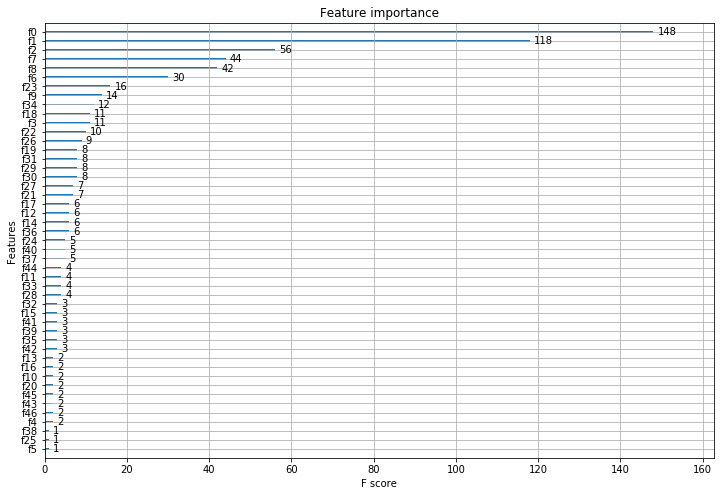

In [91]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(xgb, ax=ax)
plt.savefig('/content/drive/My Drive/Stats202_FinalProject/Figures/feature_importance_XGBoost.png')

In [0]:
#extract most important features
feature_names = list(training_poly.columns)
important_features_indexes = [i for i,val in enumerate(xgb.feature_importances_) if val != 0]
important_features = [feature_names[i] for i in important_features_indexes]

In [78]:
#select only features with nonzero importance
training_final = training_poly[important_features]
testing_final = testing_poly[important_features]

print("Training set shape: ", training_final.shape)
print("Testing set shape: ", testing_final.shape)

Training set shape:  (5106, 47)
Testing set shape:  (1962, 47)


####Re-train with updated feature set

In [79]:
X_train, X_val, y_train, y_val = train_test_split(training_final, training_copy['LeadStatus'], test_size = 0.2, random_state = 1 )

X_train, X_val, testing_scaled = scale_impute(X_train, X_val, testing_final)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

####Predict

In [80]:
y_pred = xgb.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.68%


In [81]:
test_pred = xgb.predict_proba(testing_scaled)[:,1]
test_pred[:15]


array([0.41273656, 0.2063273 , 0.6843928 , 0.74249125, 0.8777853 ,
       0.21153426, 0.72406906, 0.77136457, 0.9024401 , 0.9488115 ,
       0.18166403, 0.6703286 , 0.7377292 , 0.88540506, 0.85317653],
      dtype=float32)

In [0]:
results_xgb = pd.DataFrame(testing_poly['AssessmentiD'])
results_xgb.rename(columns={"AssessmentiD":"AssessmentID"})
results_xgb['LeadStatus'] = test_pred

results_xgb.to_csv('classification_submission_xgb.csv', index = False)